In [22]:
import torch; import torch.nn as nn; from torch.optim import lr_scheduler
import torch.optim as optim; from torch.utils.data.dataset import random_split as split 
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torchaudio import transforms

from tqdm import trange
import time
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt 
import numpy as np
import librosa 
from sklearn.model_selection import train_test_split
import pandas as pd
import math
import os

MIN_SAMPLES = True
PATH_ANNOTATIONS = 'Wingbeats/min_annotations.txt' if MIN_SAMPLES else 'Wingbeats/annotations.txt'
n_classes = 6
lr = 1e-4
n_epochs = 50
batch_size = 64
SAMPLE_RATE = 8_000
nyquist_frequency = SAMPLE_RATE / 2
classes = ['An. gambiae', 'C. pipiens', 'C. quinquefasciatus', 'Ae. albopictus', 'An. arabiensis', 'Ae. aegypti']
n_fft = 256
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available else 'cpu'

In [23]:
def dividirDatos(archivoAnnotaciones, test_size=0.2, random_state=42):
    df = pd.read_csv(archivoAnnotaciones)
    train_df, test_df = train_test_split(
        df, 
        test_size=test_size,
        random_state=random_state,
        stratify=df['label']
    )
    print('Total = ', len(df))
    print('Total train = ', len(train_df))
    print('Total test = ', len(test_df))
    return train_df, test_df

In [24]:
class AudioDatasetFromTxt(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        audio_path = self.dataframe.iloc[index]['file_path']
        label = self.dataframe.iloc[index]['label']
        
        waveform, _ = librosa.load(audio_path, sr=SAMPLE_RATE)
        
        waveform = torch.from_numpy(waveform).float().unsqueeze(0)
        
        if self.transform:
            spectrogram = self.transform(waveform)
            return spectrogram, label
        else:
            return waveform, label

In [25]:
spectrogram = transforms.Spectrogram(n_fft=n_fft, hop_length=n_fft//6)

In [26]:
train_df, test_df = dividirDatos(PATH_ANNOTATIONS)

Total =  115782
Total train =  92625
Total test =  23157


In [27]:
train_dataset = AudioDatasetFromTxt(train_df, transform=spectrogram)
test_dataset = AudioDatasetFromTxt(test_df, transform=spectrogram)

subgroups = ['train', 'val', 'test']

n_train = int(len(train_dataset) * 0.9)
n_val = math.ceil(len(train_dataset) * 0.1)
train_dataset, val_dataset = split(train_dataset, [n_train, n_val], 
                                   generator=torch.manual_seed(42))
datasets_Audio = [train_dataset, val_dataset, test_dataset]
audioFolder = {
    x : datasets_Audio[i]
    for i, x in enumerate(subgroups)
}
# Crear dataloaders
dataloaders = { x : torch.utils.data.DataLoader(audioFolder[x], shuffle=True, 
                                                batch_size=batch_size, num_workers=4)
               for x in subgroups}
test_loader = DataLoader(audioFolder['test'], batch_size=batch_size, shuffle=False)
dataset_size = {x : len(audioFolder[x])
                for x in subgroups}
print(dataset_size)
print(n_train, n_val)

{'train': 83362, 'val': 9263, 'test': 23157}
83362 9263


In [28]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    df = pd.DataFrame(
        np.empty([num_epochs, 5]), 
        index=np.arange(num_epochs),
        columns=['loss_train', 'acc_train', 'loss_val', 'acc_val', 'lr']
    )
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        rangeEpoch = trange(num_epochs)
        for epoch in rangeEpoch:
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)
            # Each epoch has a training and validation phase 
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()
                
                running_loss = 0.0
                running_correct = 0
                # Iterate over data
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()
                    # forward 
                    # track history only if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        # backward + optimizer only if training phase 
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                        
                    #@ stadistics
                    running_loss =+ loss.item() * inputs.size(0)
                    running_correct += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()
                    df.iloc[epoch, 4] = optimizer.param_groups[0]['lr']
                    
                epoch_loss = running_loss / dataset_size[phase]
                epoch_acc = running_correct.double() / dataset_size[phase]
                
                if phase == 'train':
                    df.iloc[epoch, 0], df.iloc[epoch, 1] = epoch_loss, epoch_acc.item()
                else:
                    df.iloc[epoch, 2], df.iloc[epoch, 3] = epoch_loss, epoch_acc.item()
                
                rangeEpoch.set_description("train_loss=%.5f" % df.iloc[epoch, 0])
                rangeEpoch.set_postfix(
                            {'train_acc':df.iloc[epoch,1], 'test_acc':df.iloc[epoch, 3]}
                )
                
                if phase == 'val' and epoch_acc > best_acc:
                    torch.save(model.state_dict(), best_model_params_path)

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60: .0f}m {time_elapsed % 60: .0f}s')
        print(f'Best val Acc {best_acc:4f}')
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, df

In [29]:
class AudioModelResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        original_first_conv = self.resnet.conv1
        self.resnet.conv1 = nn.Conv2d(
            1, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        with torch.no_grad():
            new_weights = original_first_conv.weight.mean(dim=1, keepdim=True)
            self.resnet.conv1.weight.copy_(new_weights)
        
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [30]:
#model_ft = models.resnet18(weights='IMAGENET1K_V1')
model_ft = AudioModelResNet(6)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [31]:
PATH_RESNET = './resultados/resnetAudioBalanceado.pt' if MIN_SAMPLES else './resultados/resnetAudioNoBalanceado.pt'
PATH_CSV_RESULTADOS = './resultados/resnetResultadoBalanceado.csv' if MIN_SAMPLES else './resultados/resnetResultadoNoBalanceado.csv'
if not os.path.exists(PATH_RESNET):
    model_ft, df = train_model(model_ft, criterion, optimizer, exp_lr_scheduler, num_epochs=n_epochs)
    df.to_csv(PATH_CSV_RESULTADOS,index=False)
    torch.save(model_ft, PATH_RESNET)

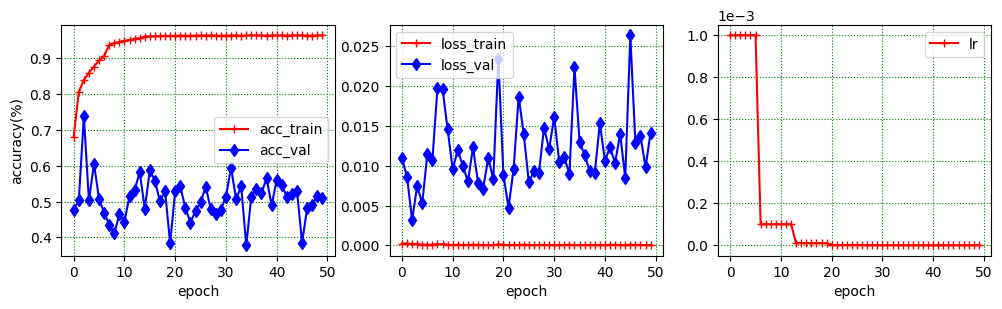

In [32]:
df = pd.read_csv(PATH_CSV_RESULTADOS)
fig, ax = plt.subplots(1, 3, figsize=(12, 3), sharex=True)
df.plot(ax=ax[0], y=[1,3], style=['r-+', 'b-d'])
df.plot(ax=ax[1], y=[0,2], style=['r-+', 'b-d'])
df.plot(ax=ax[2], y=[4], style=['r-+'])
for i in range(3):
    ax[i].set_xlabel('epoch')
    ax[i].grid(which='major', axis='both', color='g', linestyle=':')

ax[0].set_ylabel('accuracy(%)')
ax[2].ticklabel_format(style='sci',  axis='y', scilimits=(0,0))

In [34]:
def evaluation(my_dataloader):
    n_samples = len(my_dataloader.dataset)
    with torch.no_grad():
        total_loss = 0.0; n_correct = 0
        model_ft.eval()
        for i, (images, labels) in enumerate(my_dataloader):
            labels = labels.cuda(non_blocking=True)
            outputs = model_ft(images.cuda(non_blocking=True))
            predictions = torch.argmax(outputs, dim=1)
            n_correct += torch.sum(predictions == labels).item()
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / n_samples, 100 * n_correct/ n_samples

loss, accuracy = evaluation(test_loader)
print('test dataloader accuracy(%) = ', accuracy)

test dataloader accuracy(%) =  16.6688258409984
